In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tqdm
data_folder = "../data/"

## Loading Data

In [170]:
# load data from data/tickets_all.csv
ticket_all_df = pd.read_csv(data_folder + 'tickets_all.csv')
print(ticket_all_df.dtypes)

# load data from data/account.csv
account_df = pd.read_csv(data_folder + 'account.csv', encoding_errors='ignore')
print(account_df.dtypes)

# load data from data/subscriptions.csv
subscriptions_df = pd.read_csv(data_folder + 'subscriptions.csv', encoding_errors='ignore')
print(subscriptions_df.dtypes)
# print(subscriptions_df.head())


account.id           object
price.level          object
no.seats              int64
marketing.source     object
season               object
location             object
set                 float64
multiple.tickets     object
dtype: object
account.id                  object
shipping.zip.code           object
billing.zip.code            object
shipping.city               object
billing.city                object
relationship                object
amount.donated.2013        float64
amount.donated.lifetime    float64
no.donations.lifetime        int64
first.donated               object
dtype: object
account.id            object
season                object
package               object
no.seats               int64
location              object
section               object
price.level          float64
subscription_tier    float64
multiple.subs         object
dtype: object


In [171]:
train_df = pd.read_csv(data_folder + 'train.csv')
print(train_df.head())
print(train_df.shape)

test_df = pd.read_csv(data_folder + 'test.csv')
print(test_df.head())
print(test_df.shape)

        account.id  label
0  001i000000NuRo3      0
1  001i000000NuRxd      0
2  001i000000NuQGN      0
3  001i000000NuPfL      0
4  001i000000NuQkP      0
(6941, 2)
                ID
0  001i000000NuQ6Y
1  001i000000NuQXz
2  001i000000NuRDC
3  001i000000NuQeg
4  001i000000NuOQc
(2975, 1)


In [172]:


# convert price.level to float skipping invalid data
ticket_all_df['price.level'] = pd.to_numeric(ticket_all_df['price.level'], errors='coerce')
ticket_all_df['price.level'] = ticket_all_df['price.level'].astype(float)
# convert season to float (take fist number) eg 2016-2017 -> 2016
ticket_all_df['season'] = ticket_all_df['season'].str[:4].astype(float)

print(ticket_all_df.head())
print(ticket_all_df.shape)


        account.id  price.level  no.seats      marketing.source  season   
0  001i000000NuOP0          4.0         2                   NaN  2012.0  \
1  001i000000NuOYU          1.0         1                 Other  2013.0   
2  001i000000NuRS9          4.0         2                   NaN  2011.0   
3  001i000000NuRPj          3.0         1  Postcard or brochure  2013.0   
4  001i000000NuRQ1          2.0         2                   NaN  2013.0   

            location  set multiple.tickets  
0      San Francisco  4.0               no  
1    Berkeley Sunday  6.0               no  
2     Family concert  3.0               no  
3  Berkeley Saturday  2.0               no  
4  Berkeley Saturday  1.0               no  
(2808, 8)


In [173]:
# drop shitty columns from account_df
account_df_nums = account_df.drop(['shipping.zip.code', 'shipping.city', 'billing.city', 'relationship', 'billing.zip.code', 'first.donated'], axis=1)
account_df_nums.dropna(inplace=True)
print(account_df_nums.head())
print(account_df_nums.dtypes)
print(account_df_nums.shape)

# drop shitty columns from tickets_all_df
ticket_all_df_nums = ticket_all_df.drop(['marketing.source', 'location', 'multiple.tickets'], axis=1)
ticket_all_df_nums.dropna(inplace=True)
print(ticket_all_df_nums.head())
print(ticket_all_df_nums.dtypes)
print(ticket_all_df_nums.shape)

        account.id  amount.donated.2013  amount.donated.lifetime   
0  001i000000LhSrQ                  0.0                      0.0  \
1  001i000000LhyPD                  0.0                    500.0   
2  001i000000LhyPE                  0.0                    783.0   
3  001i000000LhyPF               1500.0                  28435.0   
4  001i000000LhyPG                300.0                   4969.0   

   no.donations.lifetime  
0                      0  
1                      5  
2                      7  
3                     28  
4                     16  
account.id                  object
amount.donated.2013        float64
amount.donated.lifetime    float64
no.donations.lifetime        int64
dtype: object
(19833, 4)
        account.id  price.level  no.seats  season  set
0  001i000000NuOP0          4.0         2  2012.0  4.0
1  001i000000NuOYU          1.0         1  2013.0  6.0
2  001i000000NuRS9          4.0         2  2011.0  3.0
3  001i000000NuRPj          3.0         1  2

In [174]:
# for each account.id in train_df find how many times it appears in subscriptions_df account.id and store as a new column. make value 0 if it doesn't appear
train_df['prev_subs'] = train_df['account.id'].map(subscriptions_df['account.id'].value_counts())
train_df['prev_subs'].fillna(0, inplace=True)
print(train_df.head())
print(train_df.shape)

# do same thing for test_df
test_df['prev_subs'] = test_df['ID'].map(subscriptions_df['account.id'].value_counts())
test_df['prev_subs'].fillna(0, inplace=True)
print(test_df.head())
print(test_df.shape)

        account.id  label  prev_subs
0  001i000000NuRo3      0        0.0
1  001i000000NuRxd      0        0.0
2  001i000000NuQGN      0        0.0
3  001i000000NuPfL      0        1.0
4  001i000000NuQkP      0        0.0
(6941, 3)
                ID  prev_subs
0  001i000000NuQ6Y        6.0
1  001i000000NuQXz        1.0
2  001i000000NuRDC        0.0
3  001i000000NuQeg        0.0
4  001i000000NuOQc        6.0
(2975, 2)


In [175]:
# drop duplicate account.ids for account_df_nums and ticket_all_df_nums
account_df_nums.drop_duplicates(subset='account.id', inplace=True)
ticket_all_df_nums.drop_duplicates(subset='account.id', inplace=True)


In [176]:
# join all dataframes by account.id making sure to keep as many points as possible
df = pd.merge(account_df_nums, ticket_all_df_nums, on='account.id', how='outer')
print(df.shape)
df.drop_duplicates(inplace=True)
df.fillna(0, inplace=True)
print(train_df.shape)
df = pd.merge(train_df, df, on='account.id', how='left')
# df.drop_duplicates(inplace=True)
# df.dropna(inplace=True)
df.fillna(0, inplace=True)
print(df.head())
print(df.shape)
# save to csv
df.to_csv(data_folder + 'train_data.csv')

# split data into trainign and validation sets
train_data, val_data = train_test_split(df, test_size=0.05, stratify=df['label'])
# print(train_data.shape)
# print(val_data.shape)

## split in to features and labels
train_x  = train_data.drop(['account.id', 'label'], axis=1)
train_y = train_data['label']

val_x = val_data.drop(['account.id', 'label'], axis=1)
val_y = val_data['label']

(19833, 8)
(6941, 3)
        account.id  label  prev_subs  amount.donated.2013   
0  001i000000NuRo3      0        0.0                  0.0  \
1  001i000000NuRxd      0        0.0                  0.0   
2  001i000000NuQGN      0        0.0                  0.0   
3  001i000000NuPfL      0        1.0                  0.0   
4  001i000000NuQkP      0        0.0                  0.0   

   amount.donated.lifetime  no.donations.lifetime  price.level  no.seats   
0                      0.0                      0          0.0       0.0  \
1                      0.0                      0          0.0       0.0   
2                      0.0                      0          0.0       0.0   
3                      0.0                      0          0.0       0.0   
4                      0.0                      0          0.0       0.0   

   season  set  
0     0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
(6941, 10)


In [177]:
# set up the test set 
# rename test_df['ID'] to test_df['account.id']
test_df.rename(columns={'ID': 'account.id'}, inplace=True)
# # join test_df with account_df_nums by account.id
# temp_df = pd.merge(account_df_nums, ticket_all_df_nums, on='account.id', how='outer')
# print(temp_df.shape)
# temp_df.drop_duplicates(inplace=True)
# print(test_df.shape)
# test_data = pd.merge(test_df, temp_df, on='account.id', how='left')
# test_data.drop_duplicates(inplace=True)
# test_data.fillna(0, inplace=True)
print(test_df.shape)
# I need to merge the frames so that I get the columns from account_df_nums and ticket_all_df_nums
# I need to make sure that I keep all the rows from test_df and exactly those rows
# merge the dataframes appropriately
test_data_temp = pd.merge(test_df, account_df_nums, on='account.id', how='left')
test_data = pd.merge(test_data_temp, ticket_all_df_nums, on='account.id', how='left')

test_data.fillna(0, inplace=True)



print(test_data.head())
print(test_data.shape)
print(test_data.dtypes)



(2975, 2)
        account.id  prev_subs  amount.donated.2013  amount.donated.lifetime   
0  001i000000NuQ6Y        6.0                  0.0                   1818.0  \
1  001i000000NuQXz        1.0                  0.0                     75.0   
2  001i000000NuRDC        0.0                  0.0                    100.0   
3  001i000000NuQeg        0.0                  0.0                    100.0   
4  001i000000NuOQc        6.0                  0.0                     88.0   

   no.donations.lifetime  price.level  no.seats  season  set  
0                      7          0.0       0.0     0.0  0.0  
1                      1          0.0       0.0     0.0  0.0  
2                      1          2.0       2.0  2012.0  2.0  
3                      1          0.0       0.0     0.0  0.0  
4                      2          0.0       0.0     0.0  0.0  
(2975, 9)
account.id                  object
prev_subs                  float64
amount.donated.2013        float64
amount.donated.lifetim

In [162]:
print(train_y.head())
# check to see if all values in train_y are 0 or 1
print(train_y.value_counts())

537     0
5137    0
6553    0
219     0
5175    0
Name: label, dtype: int64
label
0    6445
1     349
Name: count, dtype: int64


## Initialize Model

In [62]:
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

### LOGISTIC REGRESSION

In [63]:
# initialize a logistic regression from sklearn
logreg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=10000)

print(train_x.shape)
# fit the model to the training data
logreg.fit(train_x, train_y)

# predict on the validation data
y_pred = logreg.predict(val_x)

# calculate the accuracy
acc = np.mean(y_pred == val_y)
print("Accuracy: {:.2f}".format(acc))

(742, 8)
Accuracy: 0.92


In [65]:
# predict on the test data
y_pred = logreg.predict(test_data.drop(['account.id'], axis=1))

# save the predictions to a csv file with two columns: account.id and label
results = pd.DataFrame({'ID': test_data['account.id'], 'Predicted': y_pred})
results.to_csv(data_folder + 'results.csv', index=False)

### NEURAL NETWORK

In [178]:
# Normalize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_x)
X_test = scaler.transform(test_data.drop(['account.id'], axis=1))

In [179]:
# set up data loaders
def prep_dataloaders(X_train,y_train,X_val, y_val, X_test,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                            torch.from_numpy(np.array(y_train)).float().view(-1,1))
    testset = TensorDataset(torch.from_numpy(np.array(X_test)).float())

    valset = TensorDataset(torch.from_numpy(np.array(X_val)).float(), 
                            torch.from_numpy(np.array(y_val)).long())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader, valloader

batchsize = 32
trainloader,testloader, valloader = prep_dataloaders(X_train,train_y, val_x, val_y, X_test,batchsize)

In [180]:
# define the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(8, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = torch.sigmoid(self.out(x))
        return x

nnet = Net()

In [181]:
# Define the cost / loss function
# binary cross entropy loss
criterion = nn.BCELoss()
# Define the method of updating the weights each iteration using ATOM optimizer
optimizer = optim.Adam(nnet.parameters(), lr=0.001)
# optimizer = optim.SGD(nnet.parameters(), lr=0.001, momentum=0.9)

In [182]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device):
    # model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    train_cost = []
    for epoch in range(num_iter):

        train_running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # Add the loss to running loss for the epoch
            train_running_loss += loss.item()

        train_cost.append(train_running_loss)
    return train_cost

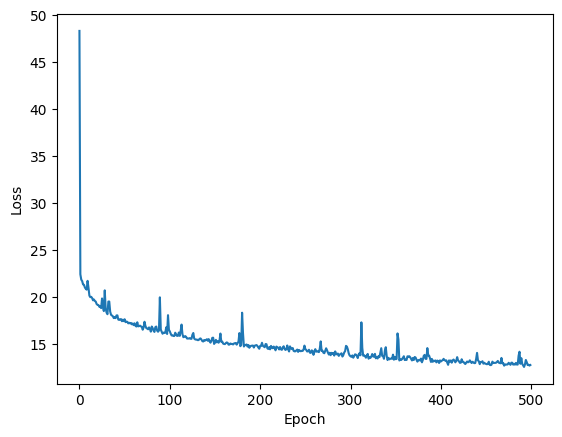

In [183]:

# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
device = torch.device("cpu")
# Number of iterations (epochs) to train
n_iter = 500

cost_path = train_model(nnet,criterion,optimizer,trainloader,n_iter,device)

plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [190]:
# generate predictions using test data 
def predict(model,testloader,device):
    model.eval() # Set the model to evaluation mode
    predictions = []
    for i, data in enumerate(testloader):
        inputs = data[0].to(device)
        outputs = model.forward(inputs)
        predictions.append(outputs.detach().numpy())
    return np.concatenate(predictions)

# predict on the test data
y_pred = predict(nnet,testloader,device)
print(y_pred.flatten())
preds = pd.DataFrame({'ID': test_data['account.id'], 'Predicted': y_pred.flatten()})
preds.to_csv(data_folder + 'preds.csv', index=False)

[5.7321385e-04 3.2213435e-02 5.3584995e-07 ... 3.3608846e-02 7.1697287e-02
 3.1787653e-02]


In [192]:
# save predictions to csv file
# copy p_pred
y_pred_thresh = y_pred.copy()
threshold = 0.001
y_pred_thresh[y_pred > threshold] = 1
y_pred_thresh[y_pred <= threshold] = 0
results = pd.DataFrame({'ID': test_data['account.id'], 'Predicted': y_pred_thresh.flatten()})


# keep only unique IDs
results_unique = results.drop_duplicates(subset='ID', keep='first')
results_unique.to_csv(data_folder + 'results.csv', index=False)